## Intro to QuantumOptics.jl

In [184]:
using QuantumOptics
using Plots
using LaTeXStrings
pyplot()

Plots.PyPlotBackend()

### Generating bases

Out of the box, QuantumOptics.jl defines many common types of bases with operators predefined. While it's not difficult to define a basis yourself (i.e. using `GenericBasis()`), these default bases are useful for quick calculations. Some examples:

In [185]:
sb = SpinBasis(1//2)    # A generic S = 1/2 spin basis.
sz = sigmaz(sb)         # What is the Sz matrix? Note that the output is sparse.

Operator(dim=2x2)
  basis: Spin(1/2)
  [1, 1]  =  1.0+0.0im
  [2, 2]  =  -1.0+0.0im

In [187]:
fb = FockBasis(10)      # A basis containing a few number states
cfb = create(fb)        # What is the creation operator in this basis?

Operator(dim=11x11)
  basis: Fock(cutoff=10)
  [2 ,  1]  =  1.0+0.0im
  [3 ,  2]  =  1.41421+0.0im
  [4 ,  3]  =  1.73205+0.0im
  [5 ,  4]  =  2.0+0.0im
  [6 ,  5]  =  2.23607+0.0im
  [7 ,  6]  =  2.44949+0.0im
  [8 ,  7]  =  2.64575+0.0im
  [9 ,  8]  =  2.82843+0.0im
  [10,  9]  =  3.0+0.0im
  [11, 10]  =  3.16228+0.0im

These operators are just dressed up (sparse) matrices. Apart from their entry values they contain information about the basis they work on (to get a list of all the fields do `fieldnames(typeof( cfb ))`). If we would want to we could grab the data like this:

In [191]:
cfb.data              # What is the actual matrix comprising this operator?

11×11 SparseArrays.SparseMatrixCSC{Complex{Float64},Int64} with 10 stored entries:
  [2 ,  1]  =  1.0+0.0im
  [3 ,  2]  =  1.41421+0.0im
  [4 ,  3]  =  1.73205+0.0im
  [5 ,  4]  =  2.0+0.0im
  [6 ,  5]  =  2.23607+0.0im
  [7 ,  6]  =  2.44949+0.0im
  [8 ,  7]  =  2.64575+0.0im
  [9 ,  8]  =  2.82843+0.0im
  [10,  9]  =  3.0+0.0im
  [11, 10]  =  3.16228+0.0im

We can combine bases using the tensorproduct $\otimes$ (in a code cell: type `\otimes` and hit tab). Let's construct the combined basis of a spin-1/2 particle and some number states. This would be an appropriate basis for a two-level atom in a harmonic oscillator (where the number basis would span the harmonic oscillator states), or an atom coupled to a quantized field (such as in the Jaynes-Cummings model).

In [196]:
comb_basis = sb ⊗ fb

[Spin(1/2) ⊗ Fock(cutoff=10)]

### Generating states

When looking at dynamics, we'll need to specify an initial state, and when looking at eigenstates we'll also need an understanding of how QuantumOptics.jl deals with states. Some bases have predefined states, for instance:

In [197]:
sd = spindown(sb)                # Have the spin pointing down

Ket(dim=2)
  basis: Spin(1/2)
 0.0 + 0.0im
 1.0 + 0.0im

In [198]:
coh_st = coherentstate(fb, 1)   # Give me a coherent state

Ket(dim=11)
  basis: Fock(cutoff=10)
  0.6065306597126334 + 0.0im
  0.6065306597126334 + 0.0im
  0.4288819424803534 + 0.0im
 0.24761510494160163 + 0.0im
 0.12380755247080082 + 0.0im
 0.05536842069051653 + 0.0im
 0.02260406309258736 + 0.0im
  0.0085435327946571 + 0.0im
 0.00302059498719585 + 0.0im
 0.00100686499573195 + 0.0im
 0.00031839866828087 + 0.0im

It's also possible to define a generic ket or bra. We could also define our spin down state as follows:

In [199]:
sd = Ket(sb, [0, 1])

Ket(dim=2)
  basis: Spin(1/2)
 0.0
 1.0

Constructing a product state that spans multiple bases is also done with the tensor product. The following could be used to describe a two-level atom in its ground state, coupled to a quantized field with one photon on average.

In [200]:
comb_state = sd ⊗ coh_st

Ket(dim=22)
  basis: [Spin(1/2) ⊗ Fock(cutoff=10)]
                 0.0 + 0.0im
  0.6065306597126334 + 0.0im
                 0.0 + 0.0im
  0.6065306597126334 + 0.0im
                 0.0 + 0.0im
  0.4288819424803534 + 0.0im
                 0.0 + 0.0im
 0.24761510494160163 + 0.0im
                 0.0 + 0.0im
 0.12380755247080082 + 0.0im
                 0.0 + 0.0im
 0.05536842069051653 + 0.0im
                 0.0 + 0.0im
 0.02260406309258736 + 0.0im
                 0.0 + 0.0im
  0.0085435327946571 + 0.0im
                 0.0 + 0.0im
 0.00302059498719585 + 0.0im
                 0.0 + 0.0im
 0.00100686499573195 + 0.0im
                 0.0 + 0.0im
 0.00031839866828087 + 0.0im

#### Expectation values

Observables can be evaluated in the following way:

In [201]:
expect(sigmaz(sb), spindown(sb))            # <Sz> for a spin pointing down

-1.0 + 0.0im

In [202]:
expect(number(fb), coherentstate(fb, 1))    # The average number of photons, a little bit less than 1 due to the basis size

0.9999998885745217 + 0.0im

When calculating expectation values on composite bases, it's important to make sure the operator is defined on that composite basis as well. The operator $S_z$, for instance, only acts on the spin sector of our composite basis. We can expand it by taking the tensor product with the identity operator: $S_z^{(f)} = S_z \otimes \mathcal{I}$:

In [203]:
comb_sz = sigmaz(sb) ⊗ identityoperator(fb)
expect(comb_sz, comb_state)

-0.9999999899522336 + 0.0im

### Simulating dynamics

Let's have a look at the Jaynes-Cummings Hamiltonian (in the interaction picture, on resonance, and in units of $\hbar$):
$$
    \mathcal{H} = \frac{\Omega}{2} \left( \sigma_+ a + \sigma_- a^\dagger \right)
$$

In [204]:
Ω = 1
H = Ω / 2 * (sigmap(sb) ⊗ destroy(fb) + sigmam(sb) ⊗ create(fb));

Calculating its ground state is simple (`eigenstate(H, 1)`), but it's not so interesting for this particular system. Let's have a look at some of the dynamics instead. We start with our atom in the ground state (spin down) and one photon in the field mode. 

In [212]:
tax = 0:0.01:10
ψ0 = spindown(sb) ⊗ fockstate(fb, 1)
tout, ψt = timeevolution.schroedinger( tax, ψ0, H );

We need to extract some observables from the time-evolved state:

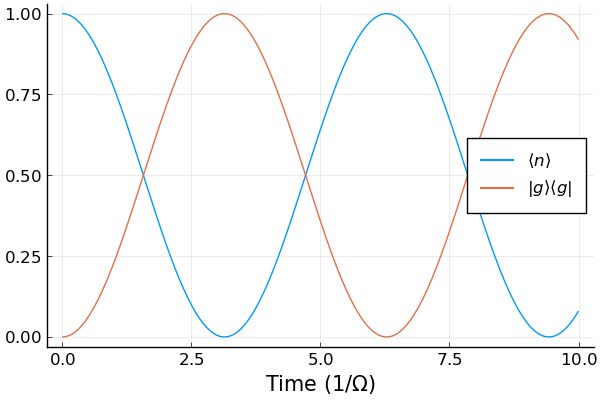

In [213]:
num_t = real([ expect( identityoperator(sb) ⊗ number(fb), ψ ) for ψ in ψt ])
spin_t = real([ expect( sigmaz(sb) ⊗ identityoperator(fb), ψ ) for ψ in ψt ])

plot(tax, num_t, label = L"\langle n \rangle",
    xlabel = L"Time ($1/\Omega$)",
    xguidefont = font(15),
    tickfont = font(12),
    legendfont = font(12))
plot!(tax, spin_t ./2 .+ 0.5, label = L"|g\rangle\langle g|")

#### Other cool features of QuantumOptics.jl
* It's possible to do semiclassical calculations, where one or more of the observables is a classical variable.
* Simulating open quantum systems, either using the density matrix or using the Monte-Carlo wave function method.
* Very easy to use interface to many-body bases, states, and operators.